<a href="https://colab.research.google.com/github/tariqdaouda/CAVEPM2019/blob/master/CAVEPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation
Installing all the packages needed for running the code

In [0]:
!pip install sklearn
!pip install pandas
!pip install altair
!pip install seaborn
!git clone https://github.com/tariqdaouda/CAVEPM2019

Cloning into 'CAVEPM2019'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


# Initialisation

In [0]:
import pandas as pd
import numpy as np
import sklearn


In [0]:
#functions for cleaning and formating data
def dataframe_encode(df) :
  """
  - Transform all nominal values into categorical values
  - Sets all numerical values between 0 and 1
  - Returns the transformed dataset along with a dict to retreive cateory names
  from numerical labels
  """
  translation = {}
  for colname in df.columns :
    if df[colname].dtype == np.object :
      enc = df[colname].astype("category")
      codes = df[colname].astype("category").cat.codes.astype("int32")
      codes = codes + max(abs(codes)) + 1
      
      translation[colname] = { str(code): name for name, code in zip(df[colname], codes) }
      df[colname] = codes
    else :
      df[colname] = df[colname].astype("float32") / df[colname].max()
  return df, translation

def df_to_dataset(df, target_column) :
  x = df.copy()
  y = df[target_column]
  
  x = x.drop([target_column], axis=1)
  
  return x, y

def class_to_label(labels, translation) :
  return pd.Series(labels).astype("str").replace(translation)

def remove_nominal(df) :
  return df.select_dtypes(include=['float32'])

def scale_normalize(df) :
  return df / df.max()
 

def normalize(df) :
  return (df- df.mean()) / df.std()

# Data handling

In [0]:
#Loading the horse dataset
horse_original = pd.read_csv("CAVEPM2019/data/horse-colic-dataset/horse.csv")
horse_original = horse_original.fillna(0) #replace NaN values by 0
for colname in ('hospital_number', 'lesion_1', 'lesion_2', 'lesion_3') :
  horse_original[colname] = horse_original[colname].astype("object") #hospital numbers are not real numerical values
horse_original.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,0,more_3_sec,extreme_pain,absent,severe,0,0,0.0,decreased,distend_large,45.0,8.4,0,0.0,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,0,0,pale_cyanotic,less_3_sec,mild_pain,absent,slight,0,0,0.0,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,0,0,0.0,normal,normal,33.0,6.7,0,0.0,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,0,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,0,0,dark_cyanotic,more_3_sec,0,0,0,0,0,0.0,0,0,74.0,7.4,0,0.0,died,no,4300,0,0,no


In [0]:
#Cleaning and formating data
horse, translations = dataframe_encode(horse_original)
horse.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,2,2,408,0.943627,0.358696,0.291667,7,9,7,7,9,6,8,4,4,0.000000,7,7,0.600000,0.094382,4,0.000000,3,2,116,6,2,2
1,3,2,497,0.960784,0.478261,0.208333,5,5,12,6,10,6,9,4,4,0.000000,6,11,0.666667,0.955056,6,0.198020,4,2,74,6,2,2
2,2,2,423,0.938725,0.217391,0.250000,8,8,13,6,10,8,7,4,4,0.000000,9,10,0.440000,0.075281,4,0.000000,5,2,61,6,2,3
3,3,3,547,0.958333,0.891304,0.875000,6,8,10,7,8,6,8,5,5,0.666667,7,6,0.640000,0.080899,7,0.524752,3,3,74,6,2,3
4,2,2,416,0.914216,0.565217,0.364583,5,5,10,7,6,5,5,4,4,0.000000,5,6,0.986667,0.083146,4,0.000000,3,2,97,6,2,2


In [0]:
translations["outcome"]

{'3': 'died', '4': 'euthanized', '5': 'lived'}

# K Nearest Neighbours

In [0]:
from sklearn.neighbors import KNeighborsClassifier

X, y = df_to_dataset(horse, "outcome")

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X, y) 

print('Accuracy:')
print(KNN.score(X, y))

Accuracy:
0.7859531772575251


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train) 

print('Accuracy:')
print(KNN.score(X_test, y_test))

Accuracy:
0.6


In [0]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

best_score, best_k, best_model = -1, None, None
for k in (3, 5, 7, 11, 13) :
  KNN = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(KNN, X_train, y_train, cv=10)
  avg = np.mean(scores)
  
  if avg > best_score:
    best_score, best_k, best_model = avg, k, KNN
  
  print("---------")
  print("K:", k)
  #print('10 X Val Accuracy:', scores)
  print('Average:', avg)

print("===========")

print("Best k:", best_k, "Best score:", best_score)

KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_train, y_train)
print('Test accuracy:')
print(KNN.score(X_test, y_test))

---------
K: 3
Average: 0.6376561264822134
---------
K: 5
Average: 0.6138992094861659
---------
K: 7
Average: 0.6275210803689065
---------
K: 11
Average: 0.6189156785243741
---------
K: 13
Average: 0.619096837944664
Best k: 3 Best score: 0.6376561264822134
Test accuracy:
0.65


# Feedforward neural network

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X, y = df_to_dataset(horse_original, "outcome")
X = remove_nominal(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 100, 3), max_iter=1000)
mlp.fit(X_train, y_train)
print("Train accuracy:", mlp.score(X_train, y_train))
print("Test accuracy:", mlp.score(X_test, y_test))

Train accuracy: 0.7866108786610879
Test accuracy: 0.6333333333333333


# Dimensionality reduction

In [0]:
numerical_horse = remove_nominal(horse_original)
numerical_horse.head()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
0,0.943627,0.358696,0.291667,0.000000,0.600000,0.094382,0.000000
1,0.960784,0.478261,0.208333,0.000000,0.666667,0.955056,0.198020
2,0.938725,0.217391,0.250000,0.000000,0.440000,0.075281,0.000000
3,0.958333,0.891304,0.875000,0.666667,0.640000,0.080899,0.524752
4,0.914216,0.565217,0.364583,0.000000,0.986667,0.083146,0.000000


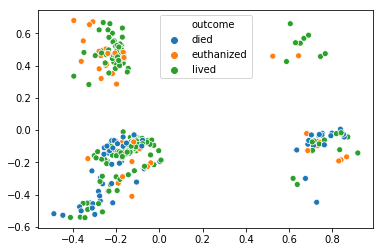

In [0]:
from sklearn.decomposition import PCA
import altair as alt
import seaborn as sns

numerical_horse = scale_normalize(numerical_horse)
pca = PCA(n_components=2)
x2 = pca.fit_transform(numerical_horse)

outcome = class_to_label(y, translations['outcome'])
pca_reduced_horse_2d = {'PC1': x2[:, 0], 'PC2': x2[:, 1], 'Outcome': outcome}
ax = sns.scatterplot(x="PC1", y="PC2", hue="Outcome", data=pca_reduced_horse_2d)

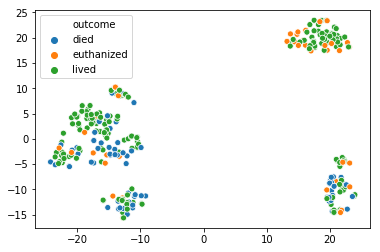

In [0]:
from sklearn.manifold import TSNE

numerical_horse = scale_normalize(numerical_horse)
x3 = TSNE(n_components=2, perplexity=30.0).fit_transform(numerical_horse)


outcome = class_to_label(y, translations['outcome'])
tsne_reduced_horse_2d = {'PC1': x3[:, 0], 'PC2': x3[:, 1], 'Outcome': outcome}
ax = sns.scatterplot(x="PC1", y="PC2", hue="Outcome", data=tsne_reduced_horse_2d)

# Breast cancer dimensionality reduction

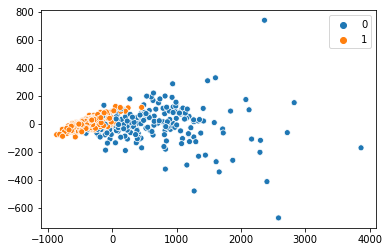

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

breast = load_breast_cancer()

pca = PCA(n_components=2)
x5 = pca.fit_transform(breast.data)

pca_reduced_breast_2d = {'PC1': x5[:, 0], 'PC2': x5[:, 1], 'Outcome': breast.target}
ax = sns.scatterplot(x="PC1", y="PC2", hue="Outcome", data=pca_reduced_breast_2d)


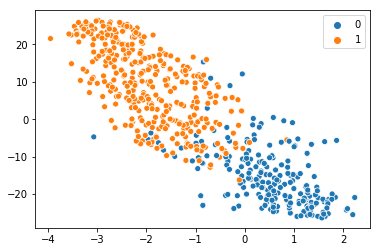

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

breast = load_breast_cancer()
x4 = TSNE(n_components=2, perplexity=70.0).fit_transform(breast.data)

tsne_reduced_breast_2d = {'PC1': x4[:, 0], 'PC2': x4[:, 1], 'Outcome': breast.target}
ax = sns.scatterplot(x="PC1", y="PC2", hue="Outcome", data=tsne_reduced_breast_2d)